
# **SER Tecnicas de Hiperparametrizacion**

## English
Este notebook es una continuacion del estudio que se hace sobre las emociones en la prosodia de la voz, teniendo en cuenta los resultados y avances del analisis jsutamente anterior. Como en las versiones anteriores de esta serie, en el analisis se usara RAVDESS como dataset en el idioma **ingles**, se llevara a cabo una clasificacion de 7 emociones. Los detalles de dicho dataset son descritos mas adelante.


En esta parte se aplicaran tecnicas de parametrizacion del modelo para conseguir un mejor rendimiento. A saber:
- Early Stopping
- Learning Rate Scheduler
- L2 Regularizer


</br>

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [ ]:
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



In [ ]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
LPATH_DATA = 'SpeechEmotionRecognition/data/procesed/' 
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## **1. CARGA DE DATOS**
Para este analisis utilizare el dataset de [RAVDESS](https://zenodo.org/record/1188976.) (Ryerson Audio-Visual Database of Emotional Speech and Song), el cual contiene 7356 archivos (24.8 GB) entre los cuales podemos encontrar 3 modalidades: **solo audio** (en 16 bit, 48 kHz y en formato .wav), **audio-video** (720p H.264, AAC 48kHz, .mp4) y **solo video** sin sonido.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'RAVDESS']
Size of the dataset: 1440 

sad         192
calm        192
happy       192
disgust     192
fear        192
surprise    192
angry       192
neutral      96
Name: emotion, dtype: int64


In [ ]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
1169,angry,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
257,calm,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
668,happy,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1077,surprise,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
317,sad,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1216,happy,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
114,surprise,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
756,angry,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1032,calm,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
1352,angry,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...


# **2. EXPLORACION DE LOS DATOS**

### **2.1 EXPOSICION DE UNA MUESTRA ALEATORIA**



In [ ]:

def plot_audio_waveform(audio_sample):
  '''
  Muestra la forma de la onda sonora a partir de una muestra.

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio 
  
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  '''
  Muestra el espectograma a partir de una muestra de audio

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
  '''
  Imprime el especograma de una muestra de audio en una ventana de tiempo
  
  Arguments
  ---------
  audio: np.ndarray
    Muestra de audio
  sample_rate: int, optional
    Frecuencia de muestreo de la muestra de audio
  window_size: int, optional

  step_size: int, optional
  
  eps: int, optional
  '''
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/Actor_07/03-01-06-02-01-02-07.wav
76517


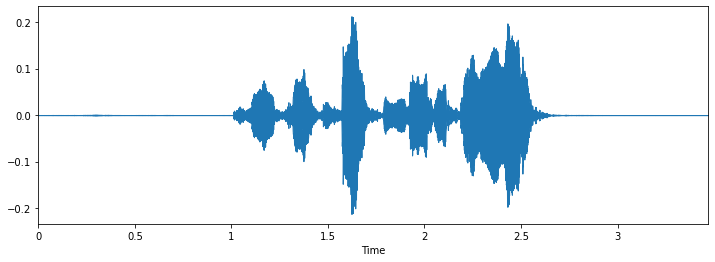

In [ ]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Dibuja la grafica de la onda sonora
plot_audio_waveform(random_sample)
# Esta es la muestra sonora
ipd.Audio(random_sample, rate=16000)


### **2.2 COMPARATIVA DE TODAS LAS EMOCIONES**
Ahora que hemos conseguido extraer la grafica de una determinada muestra de sonido, vamos a comparar la graficas correspondientes a las muestras de sonido de distintas emociones respectivamente. Para ello vamos a distinguir por genero, ya que podria suponer una diferencia.

In [ ]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  
  Arguments
  --------- 
    gender: str
      Genero del actor en el audio
    rows:  int, optional
      Filas en las que se muestra. 5 por defecto
    cols: int, optional
      Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


## **3 TECNICAS DE _DATA AUGMENTATION_ EN SONIDO**

In [ ]:
def white_noise(data):
  '''
  Agrega ruido blanco a una pista de audio
  '''
  # print("data: {}".format(data.shape))
  wn_spectrum = np.random.randn(len(data))
  data_wn = sample_data + 0.005*wn_spectrum
  return data_wn

def shift_audio_sample(data, f_low = -5, f_high = 5, spec = 1):
  '''
  Desplaza una se;al acustica en un rango de frecuencia
  '''
  d_range = int(np.random.uniform(low=f_low, high = f_high)*spec) 
# d_range = np.random.uniform(low=1.5, high=3)
  data_shiftted = np.roll(data, d_range)
  return data_shiftted
  # librosa.display.waveplot(data_shiftted, sr=16000)
  # ipd.Audio(data_shiftted, rate=16000)

def pitch_shift(data, bins_per_octave=12, pitch_pm = 2):
  '''
  Modula el tono y modifica la velocidad de una pista de audio
  '''
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  data_pitch = librosa.effects.pitch_shift(data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)
  return data_pitch


sample_data = librosa.core.load(random_sample)[0]

### **3.1 RUIDO BLANCO**
TODO
> - Explicacion ruido blanco
> - Adjust rate spectrum
> - Comparison respective the original. How do they change?

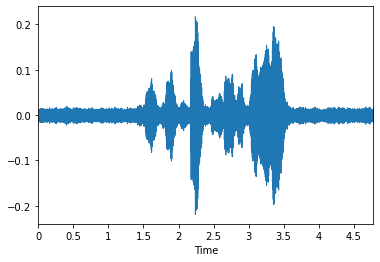

In [ ]:

data_wn = white_noise(sample_data)
librosa.display.waveplot(data_wn, sr=16000)
ipd.Audio(data_wn, rate=16000)

### **3.2 DESPLAZAMIENTO DEL SONIDO**

TODO
> [shifting](https://stackoverflow.com/questions/57362543/how-to-properly-use-pitch-shift-librosa)

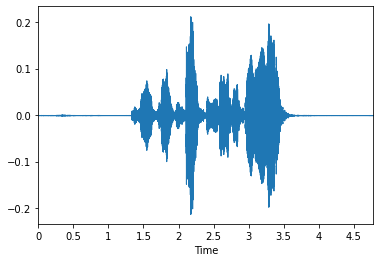

In [ ]:
d_range = int(np.random.uniform(low=-5, high = 5)*500) # Optional
# d_range = np.random.uniform(low=1.5, high=3)
data_shiftted = np.roll(sample_data, d_range)
librosa.display.waveplot(data_shiftted, sr=16000)
ipd.Audio(data_shiftted, rate=16000)

### **3.3 MODULACION DEL TONO**

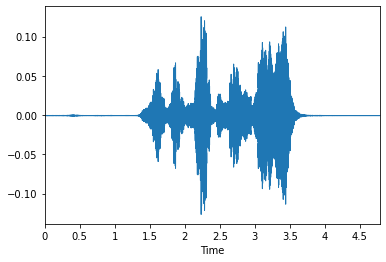

In [ ]:
bins_per_octave = 12
pitch_pm = 2
pitch_change =  pitch_pm * 2*(np.random.uniform())   
data_pitch = librosa.effects.pitch_shift(sample_data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)

librosa.display.waveplot(data_pitch, sr=16000)
ipd.Audio(data_pitch, rate=16000)

## **4. PROCESAMIENTO DE DATOS**


### **4.1 EXTRACCION DE CARACTERISTICAS**

In [ ]:
def get_features(df, modifier):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa

  Aguments
  ---------
    df : dataframe
    Dataframe que contiene el path donde se encuentra la pista de audio
    modifier: Function
    Funcion que modifica los datos

  Return
  -------
   data: np.array 
   Caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = modifier(df.path[index])
    data.loc[index] = [data_features]

  return data

def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features



def get_features_white_noise(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa habiendoles aplicado ruido blanco.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  X = librosa.core.load(random_sample)[0]

  x_data_wn = white_noise(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features


def get_features_shiftted(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa habiendo desplazado las frecuencias perviamente.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

   '''
  # X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  # x_data_shiftted = shift_audio_sample(X)
  # mfcc = librosa.feature.mfcc(y=x_data_shiftted, sr=sample_rate, n_mfcc=13)
  # data_features = np.mean(mfcc, axis = 0)

  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  X = librosa.core.load(random_sample)[0]

  x_data_wn = shift_audio_sample(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features


def get_features_pitch(pathfile):
  '''
  Aplica modulacion del tono en cada muestra y despues extrae las caracteristicas 
  usando el algoritmo MFCC
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  # X, sample_rate = librosa.load(pathfile, duration=2.5, sr=22050*2, offset=0.5)
  # x_data_pitch = pitch_shift(X)
  # mfcc = librosa.feature.mfcc(y=x_data_pitch, sr=sample_rate, n_mfcc=13)
  # data_features = np.mean(mfcc, axis = 0)

  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  X = librosa.core.load(random_sample)[0]

  x_data_wn = pitch_shift(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)


  return data_features




### 4.1.1 EXTRACCION DE CARACTERISTICAS ESTANDAR

In [ ]:
features_standard = get_features(EnglishSpeech_df, get_features_single_file)

100%|██████████| 1440/1440 [17:08<00:00,  1.40it/s]


In [ ]:
# Cada valor es una caracteristica
features_standard_df = pd.DataFrame(features_standard['data'].values.tolist())
# Concateno las columnas genero y emocion para poder dividirlo mas tarde
features_std = pd.concat((features_standard_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1) 
# Elimino filas vacias
features_std = features_std.fillna(0)

In [ ]:
random_aux = shuffle(features_std)
random_aux.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,gender,emotion
371,-484.883118,71.026062,-17.389265,13.409537,2.206051,-8.435062,-18.291603,-3.999573,-14.603395,5.681508,-8.442272,3.745054,2.496132,0.497798,-2.563040,4.767084,-7.479853,4.275789,-2.174323,0.510736,-5.055007,-0.030817,-1.067039,0.681312,2.325656,5.758283,1.965970,7.230114,3.340320,5.971576,6.616815,8.336532,5.967011,9.600657,7.808753,6.593811,3.051468,2.419879,5.221821,6.531675,male,happy
456,-690.246948,79.569763,4.134585,20.271730,-0.160909,8.117064,-4.266444,-4.350504,-6.327988,4.559724,-4.519778,0.138017,-3.067844,3.582145,-1.946532,0.674579,-3.214618,2.393646,0.035916,2.125480,1.916230,2.519438,-1.749737,1.963453,-0.926864,0.579046,0.019774,1.062148,0.517278,3.295342,1.956642,4.264358,5.302660,5.398518,3.889118,2.100121,2.784520,2.935353,4.386033,4.929913,female,disgust
863,-668.787781,73.815262,-0.040553,23.004328,13.292525,5.916445,4.940402,4.380336,-3.520422,9.159680,-0.959064,10.119045,0.506519,4.459119,1.511923,2.250512,0.750670,0.584949,1.990717,2.728622,-1.033738,2.616409,-0.605305,2.087429,-1.693120,3.401135,-2.234732,3.787262,-0.330809,2.466323,1.407179,0.951892,1.127535,1.189187,0.558285,1.595125,0.764898,0.460258,0.031090,-1.036874,male,sad
1001,-456.619110,37.201118,-10.013621,8.367192,-0.546240,6.792870,-4.978570,0.539577,-9.711415,4.915803,-0.948937,-1.097234,-0.123425,1.256378,-3.602726,4.559674,-5.517285,1.383377,0.873429,2.463259,2.886861,4.960019,3.729131,4.927180,3.105760,6.793376,5.098730,7.501795,4.711807,5.416548,4.713562,4.434396,5.581151,4.397741,2.722019,1.914146,3.384416,3.712943,3.123356,2.753304,male,fear
1314,-540.463501,30.472212,-19.334326,-0.281677,-8.792910,-2.494793,-18.783409,-5.102601,-17.537779,3.291184,-9.541223,-8.074423,-8.096327,-7.879042,-6.109760,-3.690936,-3.441043,4.840634,-2.135830,-0.319398,-0.466297,1.607602,-0.066493,7.992764,3.079523,3.851081,-0.672287,1.334723,-1.505076,3.610787,2.450204,1.299225,-0.481447,0.928736,0.254996,2.828413,1.377638,-1.205829,-0.785368,1.361185,female,surprise


### **4.2. TRATAMIENTO DE DATOS PARA EL ENTRENAMIENTO**

In [ ]:
def split_training_test(df, n_splits_=1, test_size_=0.33, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


  return x_train_norm, y_train, x_test_norm, y_test, label_encoder


def dataset_splitted_gender(dataframe, gender):
  '''
  Devuelve el dataset divido en entrenamiento y test segun el genero

  '''
  if gender == 'female':
    female_features_df = dataframe[(dataframe['gender'] == 'female')]
    X_train, X_test, Y_train, Y_test = data_process(female_features_df)

  elif gender == 'male':
    male_features_df = dataframe[(dataframe['gender'] == 'male')]
    X_train, X_test, Y_train, Y_test = data_process(male_features_df)

  elif gender == '':
    X_train, X_test, Y_train, Y_test = data_process(dataframe)

  return X_train, X_test, Y_train, Y_test




def data_process(features_df):
  '''
  Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

  '''
  # Division entre entrenamiento y test
  _X_train, _X_test, _Y_train, _Y_test =split_training_test(features_df) 

  # 2. Normaliza los datos
  x_train_norm, x_test_norm = data_normalization(_X_train, _X_test)
  # print(x_train_female_norm.shape)

  # 3. Categorización
  _X_train, Y_train, _X_test, Y_test, labels = data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
  # print(labels_female.classes_)

  # 4. Cambio de Dimensión
  X_train = np.expand_dims(_X_train, axis=2)
  X_test = np.expand_dims(_X_test, axis=2)

  return X_train, X_test, Y_train, Y_test



### **4.3 DEFINICION DEL MODELO**
Usamos el modelo que mejor resultado nos ha dado hasta ahora

In [ ]:
def model_cnn(x_train, n_classes):
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(x_train.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  return model

def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

## **5. APLICACION DE TECNICAS DE _DATA AUGMENTATION_**

### **5.1 EXPERIMENTO CON RUIDO BLANCO**

#### **5.1.1 EXTRACCION DE CARACTERISTICAS CON RUIDO BLANCO**

In [ ]:
features_wn = get_features(EnglishSpeech_df, get_features_white_noise)

100%|██████████| 1440/1440 [06:09<00:00,  3.90it/s]


In [ ]:
f_df = pd.DataFrame(features_wn['data'].values.tolist())
# Combino los dos datasets: El original y el modificado
features_wn_df = pd.concat([f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']], axis = 1)
features_complete_df = pd.concat([features_std, features_wn_df], ignore_index=True)
features_complete_df = features_complete_df.fillna(0)

#### **5.1.2 DIVISION DEL DATAFRAME**

In [ ]:

X_train_female, X_test_female, female_Y_train, female_Y_test = dataset_splitted_gender(features_complete_df, 'female')

#### **5.1.3 ENTRENAMIENTO DEL MODELO**

In [ ]:
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_6 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_7 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 128)           

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=1000, 
                        validation_data=(X_test_female, female_Y_test),
                        callbacks=[rlrp])

Epoch 1/1000
61/61 [==============================] - 1s 11ms/step - loss: 1.9716 - accuracy: 0.3169 - val_loss: 2.1024 - val_accuracy: 0.2773
Epoch 2/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.9576 - accuracy: 0.3216 - val_loss: 2.1000 - val_accuracy: 0.2647
Epoch 3/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.9795 - accuracy: 0.2948 - val_loss: 2.0951 - val_accuracy: 0.2626
Epoch 4/1000
61/61 [==============================] - 0s 7ms/step - loss: 1.9603 - accuracy: 0.3460 - val_loss: 2.0958 - val_accuracy: 0.2605
Epoch 5/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.9438 - accuracy: 0.3634 - val_loss: 2.0887 - val_accuracy: 0.2668
Epoch 6/1000
61/61 [==============================] - 0s 8ms/step - loss: 1.9561 - accuracy: 0.3330 - val_loss: 2.0865 - val_accuracy: 0.2710
Epoch 7/1000
61/61 [==============================] - 0s 7ms/step - loss: 2.0050 - accuracy: 0.2893 - val_loss: 2.0861 - val_accuracy: 0.2689
Epoch

#### **5.1.4 EVALUACION**

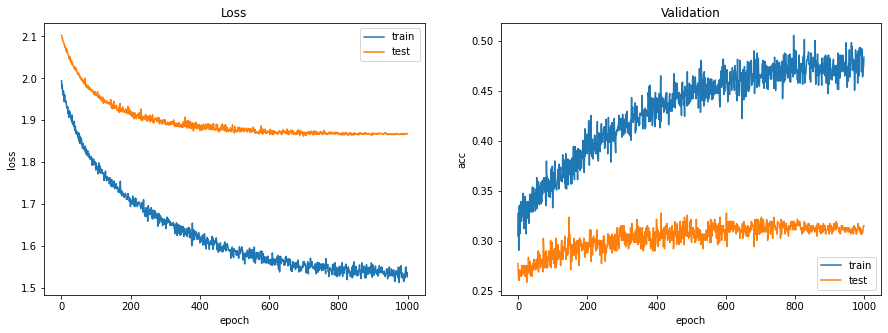

In [ ]:
plot_loss_acc(history)

In [ ]:
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

4/4 [==============================] - 0s 6ms/step - loss: 1.8682 - accuracy: 0.3151
Loss: 1.8681625127792358 
Accuracy: 31.512606143951416%


#### **OBSERVACIONES Y CONLCUSION**
Tras aumentar nuestro dataset aplicando ruido blanco, vemos que no hay necesariamente una mejora en la evaluacion resultando con un 29% de _accuracy_ y una _loss_ de 1.75. Aqui podemos observar que tanto la curva de test como la de entrenamiento avanzan proporcionalmente hasta la _epoch_ 20 donde empieza a notarse un sobreajuste cada vez mayor, sin embargo, en comparacion con la grafica que se obtuvo con datos sin modificar, el overfitting a mejorado. En general el overfitting se ha reducido pero la accuracy ni siquiera se mantiene; Esto puede ocurrir debido que el overfitting se da cuando el modelo confunde datos con 'ruido' con una se;al limpia, resultando en una buena ejecucion en el entrenamiento pero con un rendimiento pobre en la validacion. 
A;adir ruido reduce el overfitting porque se tiende a equilibrar el error entre los puntos mas cercanos con el fin de minimizar el error general. Esto da un modelo (en general) mejor y mas robusto al ruido ya que produce un error menor en la prediccion cuando se toman en cuenta los datos con ruido como los que estan libres de este, es decir, generaliza mejor. 

### **5.2 EXPERIMENTO CON DESPLAZAMIENTO DEL SONIDO**

In [ ]:
# Extraigo las caracteristicas por genero
features_shiftted = get_features(EnglishSpeech_df, get_features_shiftted)

# Extraccion de caracteristicas
f_df = pd.DataFrame(features_shiftted['data'].values.tolist())
## Combino los dos datasets: El original y el modificado
features_shiftted_df = pd.concat([f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']], axis = 1)
features_complete_df = pd.concat([features_std, features_shiftted_df], ignore_index=True)
features_complete_df = features_complete_df.fillna(0)

# Division del dataset en entrenamiento test
X_train_female, X_test_female, female_Y_train, female_Y_test = dataset_splitted_gender(features_complete_df, '')

# Entrenamiento del modelo
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_female, female_Y_test),
                        callbacks=[rlrp])


# Evaluacion
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **5.2 EXPERIMENTO CON MODULACION DEL TONO**

In [ ]:
# Extraigo las caracteristicas por genero
features_pitch = get_features(EnglishSpeech_df, get_features_pitch)

# Extraccion de caracteristicas
f_df = pd.DataFrame(features_pitch['data'].values.tolist())
# Combino los dos datasets: El original y el modificado
features_pitch_df = pd.concat([f_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']], axis = 1)
features_complete_df = pd.concat([features_std, features_pitch_df], ignore_index=True)
features_complete_df = features_complete_df.fillna(0)

# Division del dataset en entrenamiento test
X_train_female, X_test_female, female_Y_train, female_Y_test = dataset_splitted_gender(features_complete_df, 'female')

# Entrenamiento del modelo
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()
# opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=100, 
                        validation_data=(X_test_female, female_Y_test),
                        callbacks=[rlrp])


# Evaluacion
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **5.4 COMBINACION DE TECNICAS: _PITCH TUNNING & SHIFTTING_**

In [ ]:
# Extraigo las caracteristicas por genero
if 'features_shiftted' in globals() and  'features_pitch' in globals() and features_shiftted.empty and features_pitch.empty:
  features_shiftted = get_features(EnglishSpeech_df, get_features_shiftted)
  features_pitch = get_features(EnglishSpeech_df, get_features_pitch)

# Extraccion de caracteristicas
f_df_shift = pd.DataFrame(features_shiftted['data'].values.tolist())
f_df_pitch = pd.DataFrame(features_shiftted['data'].values.tolist())
## Combino los dos datasets:
features_shiftted_df = pd.concat([f_df_shift, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']], axis = 1)
features_pitch_df = pd.concat([f_df_pitch, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']], axis = 1)
comb_datasets = [features_std, features_shiftted_df, features_pitch_df]
features_complete_df = pd.concat(comb_datasets, ignore_index=True)
features_complete_df.shape

100%|██████████| 1440/1440 [08:54<00:00,  2.70it/s]


(4320, 42)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

def build_lrfn(lr_start=0.00001, lr_max=0.0008, 
               lr_min=0.00001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr

    return lrfn


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
# # Division del dataset en entrenamiento test
X_train_female, X_test_female, female_Y_train, female_Y_test = dataset_splitted_gender(features_complete_df, '')
print ("Entrenado con {} muestras. \nTesteado con {} muestras".format(X_train_female.shape[0], X_test_female.shape[0]) )
# Entrenamiento del modelo
model = model_cnn(X_train_female, female_Y_test.shape[1])
model.summary()
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history = model.fit(X_train_female, female_Y_train, 
                        batch_size=16, 
                        epochs=6000, 
                        validation_data=(X_test_female, female_Y_test), 
                        callbacks=[es, lr_schedule])



Entrenado con 2894 muestras. 
Testeado con 1426 muestras
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_21 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_22 (Activation)   (None, 5, 128)            0         
_______________________________________________________________

12/12 [==============================] - 0s 6ms/step - loss: 1.9528 - accuracy: 0.2286
Loss: 1.9527745246887207 
Accuracy: 22.86114990711212%


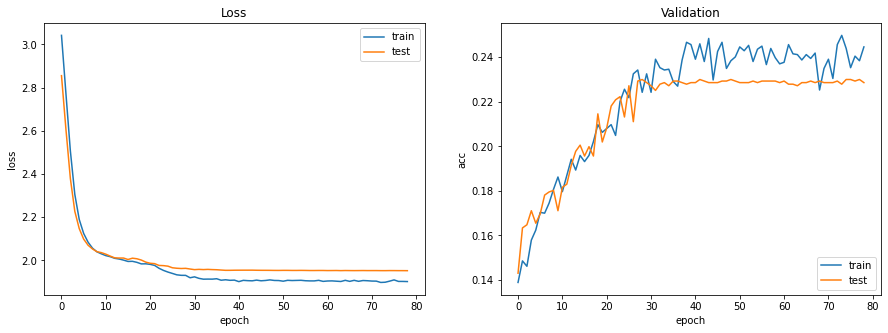

In [ ]:
# LPATH_DATA = SpeechEmotionRecognition/data/procesed/
# features_complete_df.to_hdf('features_complete.h5', key='df')
# features_shiftted_df.to_hdf('features_shiftted.h5', key='df')
# features_pitch_df.to_hdf('features_pitch.h5', key='df')
# features_standard_df.to_hdf('features_standard.h5', key='df')

# Evaluacion
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_female, female_Y_test, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

_REFERENCES_
* [validation static](https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating)
* [validation constant](https://datascience.stackexchange.com/questions/13607/validation-loss-and-accuracy-remain-constant)
* [leverage overfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
*[improve val loss and val acc](https://stackoverflow.com/questions/61520180/how-to-improve-val-loss-and-val-acc)
* [Loss curves](https://datascience.stackexchange.com/questions/52028/understanding-training-and-test-loss-plots)
* [CNN and regularization techniques](https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7)
* [Tensorflow playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62971&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&batchSize_hide=false)